# Tools of the Trade, AMS Student Conference 2018

Example notebooks by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/), University at Albany

## Animating one year of precipitable water data

We are going to download some precipitable water data from the [NCEP-DOE Reanalysis 2 project](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html), and make an animated map.

*Precipitable water is defined as the vertically integrated mass of water vapor in an atmospheric column.*

### About this notebook

This notebook illustrates use of several important tools for reproducible workflows in Atmospheric Sciences:

- Accessing data from remote servers
- The [xarray package](http://xarray.pydata.org/en/stable/) for gridded data analysis
- The [cartopy](http://scitools.org.uk/cartopy/docs/latest/) package for making maps
- The [matplotlib.animation](https://matplotlib.org/api/animation_api.html) toolkit for making animations
- The rich display system of the notebook allowing embedding of the resulting animation

The key point is that **the animation created in this notebook is completely reproducible**. 

It is a start-to-finish workflow for creating a presentation-quality animation from publicly available data.

### Start by importing all the things we need

The full list of dependencies for this notebook include

- `Python` (the programming language that runs it all)
- `numpy` (N-dimensional arrays)
- `matplotlib` (plotting)
- `pandas` (data analysis)
- `xarray` (N-dimensional gridded data analysis)
- `cartopy` (mapping)
- `Jupyter` (to run the notebook)
- `IPython` (used by `Jupyter` to run Python and rich display in the notebook)

Looks like a long list, but these are all fairly standard components of the scientific Python stack, and you should get to know them all.

You can install everything you need easily using [conda](https://conda.io/docs/) (highly recommended!). From a terminal, do this:

```
conda install xarray cartopy jupyter

```

All the other dependencies will be taken care of automatically.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
from matplotlib import cm, animation
from IPython.display import HTML

### Accessing the data

We are going to use `xarray` to open a dataset that is stored in a NetCDF file on a remote server.

It's as simple as providing a valid URL for the data file:

In [2]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis2/surface/pr_wtr.eatm.2017.nc"
pr_wtr = xr.open_dataset(url)

#### Take a look at the data loaded by `xarray`

In [3]:
pr_wtr

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, nbnds: 2, time: 1336)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 ...
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time       (time) datetime64[ns] 2017-01-01 2017-01-01T06:00:00 ...
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    pr_wtr     (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.0
    title:                           4x Daily NCEP/DOE Reanalysis 2
    history:                         created 2017/07 by NOAA/ESRL/PSD
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis


#### Some basic manipulation of the data with `xarray`

Look at the time span of the dataset:

In [4]:
pr_wtr.time

<xarray.DataArray 'time' (time: 1336)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T06:00:00.000000000',
       '2017-01-01T12:00:00.000000000', ..., '2017-11-30T06:00:00.000000000',
       '2017-11-30T12:00:00.000000000', '2017-11-30T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T06:00:00 ...
Attributes:
    long_name:           Time
    actual_range:        [ 1902192.  1910202.]
    delta_t:             0000-00-00 06:00:00
    standard_name:       time
    axis:                T
    coordinate_defines:  start

Find the maximum value in the preciptable water dataset, which will help us set a useful consistent colorscale in the animation.

Also note that the units of the data are described as part of the metadata.

In [5]:
Qmax = pr_wtr.pr_wtr.max()
print('The maximum value in the dataset is {:.1f} {}'.format(float(Qmax), pr_wtr.pr_wtr.units))

The maximum value in the dataset is 93.0 kg/m^2


### Animation time!

Making an animation usually starts with creating a static image with the basic elements in place (axes, titles, etc.).

Here we make a map of precipitable water at one particular time and set up useful labels and colorbars.

See the [cartopy documentation](http://scitools.org.uk/cartopy/docs/latest/index.html) for lots more examples and map projections.

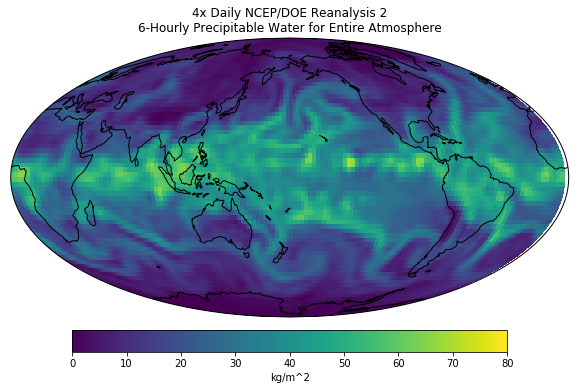

In [6]:
# Make the figure
fig = plt.figure(figsize=(10,8))
#  Create a plotting axis with a useful global projection
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=180, globe=None))
#  Choose an arbitrary time slice just to set up the plot
Q = pr_wtr.pr_wtr.sel(time='2017-11-01T00')
# Some plotting details in a dictionary
Qplot = {'vmin': 0,  # minimum value of colorscale
         'vmax': 80, # maximum value of colorscale
         'cmap': cm.viridis, # a pleasing, 'perceptually uniform' colormap
         'transform': ccrs.PlateCarree(), # the projection of the data (simple lat/lon)
        }
#  Set up the plot
cax = ax.pcolormesh(Q.lon,Q.lat,Q, **Qplot)
ax.set_global(); ax.coastlines();
#  Use metadata contained in the xarray object to label the plot!
ax.set_title(pr_wtr.title + '\n' + Q.long_name)
#  Add a colorbar under the plot
fig.colorbar(cax, orientation='horizontal', label=Q.units, fraction=0.05, pad=+0.03);

We will now loop through all the data, create the animation, and display it right here in the notebook.

*Note, this will take several minutes or more to execute!*

In [7]:
def date_as_str(da):
    '''Just render the date stamp as a simple string for plotting purposes'''
    return str(pd.Timestamp(da.time.to_pandas()))

In [8]:
#  an empty list to hold the animated objects
ims = []
#  Loop through the data
for Q in pr_wtr.pr_wtr:
    #  Plot the precipitable water 
    #  Note that we are using the `ax` object we just created for the figure above.
    item1 = ax.pcolormesh(Q.lon,Q.lat,Q, **Qplot)
    #  Add a text box with the current time stamp
    t1 = ax.text(100,60, date_as_str(Q), fontsize=12, color='w', transform=ccrs.PlateCarree())
    #  Add both elements to our list to be animated
    ims.append((item1,t1))

In [9]:
#  Create the animation
Qanim = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)
#  Display the animation in the browser
HTML(Qanim.to_html5_video())

### Hooray for fully reproducible animations!

But we still may find it useful to save the animation to disk (e.g. to imbed it in a Powerpoint presentation). That is easy to do:

In [10]:
#  Uncomment this line to save the animation file to disk:
#Qanim.save('Qanimation.mp4')

### Slides in the notebook!

One more detail, on the theme of reproducibility: *this notebook can be viewed as a slideshow!*

In fact the Powerpoint slides for my Tools of the Trade presentation feature screenshots taken directly from this notebook.

The slides are powered by [a very cool Jupyter notebook extension called RISE](https://damianavila.github.io/RISE/index.html)